In [1]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_1'
model_variant = 'base'

training_size = 3000000
test_size = 1000000

In [17]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import time
import tensorflow as tf
from keras import callbacks

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_binary
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import xai_binary

pd.set_option('display.max_columns', 10, 'display.width', 15, 'display.max_colwidth', 15, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_15980/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_15980/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,[organizati...,[organizati...,"[NOUN, VERB...",[-0.2230248...,F
1,2,"[Women, pre...","[woman, pre...","[NOUN, ADV,...",[0.27214283...,F
2,3,"[response, ...","[response, ...","[NOUN, NOUN...",[-0.0280537...,F
3,4,"[aware, all...","[aware, all...","[ADJ, NOUN,...",[-0.0157154...,F
4,5,"[point, Vis...","[point, Vis...","[NOUN, PROP...",[-0.2287299...,F
...,...,...,...,...,...,...
362024,404378,[Philosophy...,[philosophy...,"[NOUN, VERB...","[0.0, -0.25...",F
362025,404379,[Philosophy...,[Philosophy...,"[PROPN, NOU...","[0.0, 0.0, ...",F
362026,404381,"[Benefit, P...","[benefit, p...","[VERB, NOUN...",[-0.1672896...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,190061,"[single, gr...","[single, gr...","[ADJ, ADJ, ...",[-0.0262517...,M
1,193134,"[helps, fem...","[help, fema...","[VERB, ADJ,...",[-0.2512493...,M
2,269678,"[starting, ...","[start, med...","[VERB, NOUN...",[-0.1980651...,M
3,151383,"[Spending, ...","[spend, min...","[VERB, NOUN...",[-0.1359972...,M
4,349665,"[added, lik...","[add, like,...","[VERB, ADP,...",[-0.0867488...,M
...,...,...,...,...,...,...
362024,101247,"[tasks, pay...","[task, pay,...","[NOUN, VERB...",[-0.0403245...,M
362025,42869,[takeaway],[takeaway],[NOUN],[0.0],M
362026,274557,"[oil, deriv...","[oil, deriv...","[NOUN, NOUN...",[-0.0504924...,M
362027,167426,"[news, spre...","[news, spre...","[NOUN, VERB...",[-0.0781544...,M


<AxesSubplot:>

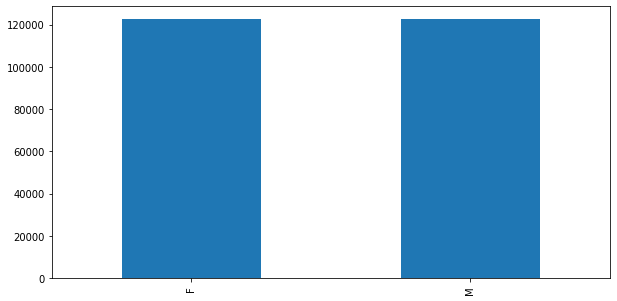

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


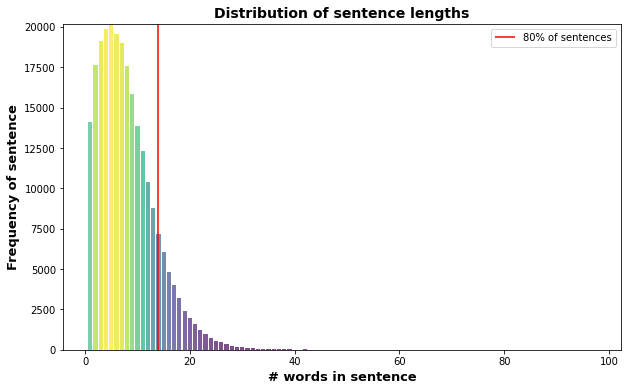

Decision boundary / 80 pct of sentence lengths is: 14


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [8]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [9]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [10]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, tensorboard_cb]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 128)           5344896   
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 5,772,674
Trainable params: 5,772,674
Non-trainable params: 0
_________________________________________________________________


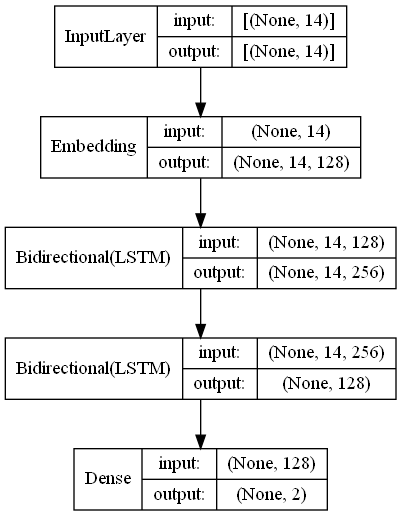

In [11]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len, mask_zero=True),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)),
    layers.Dense(2, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [12]:
# FITTING MODEL

history = model.fit(X_train, y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
6126/6126 [==============================] - 655s 105ms/step - loss: 0.4737 - accuracy: 0.7692 - val_loss: 0.4681 - val_accuracy: 0.7613
Epoch 2/20
6126/6126 [==============================] - 1591s 260ms/step - loss: 0.4077 - accuracy: 0.8081 - val_loss: 0.4796 - val_accuracy: 0.7573
Epoch 3/20
6126/6126 [==============================] - 2658s 434ms/step - loss: 0.3610 - accuracy: 0.8311 - val_loss: 0.4969 - val_accuracy: 0.7590
Epoch 4/20
6126/6126 [==============================] - 2605s 425ms/step - loss: 0.3183 - accuracy: 0.8527 - val_loss: 0.5039 - val_accuracy: 0.7570
Epoch 5/20
6126/6126 [==============================] - 2602s 425ms/step - loss: 0.2802 - accuracy: 0.8694 - val_loss: 0.5928 - val_accuracy: 0.7369
Epoch 6/20
6126/6126 [==============================] - 2631s 429ms/step - loss: 0.2495 - accuracy: 0.8843 - val_loss: 0.6514 - val_accuracy: 0.7451


red is training, blue is validation


<Figure size 432x288 with 0 Axes>

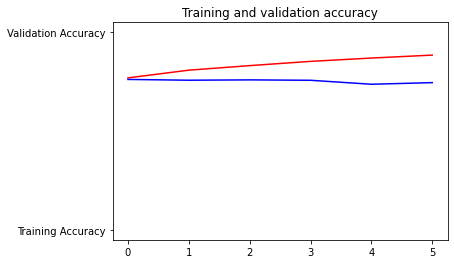

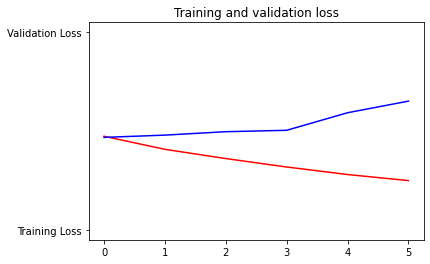

<Figure size 432x288 with 0 Axes>

In [13]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [14]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')